In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

plt.rcParams["figure.figsize"] = 9, 4.51

import expectexception

from tutorial import *

# Tutorial

## Introduction

A time series is a sequence of observations, or data points, that is arranged based on the times of their occurrence. The hourly measurement of wind speeds in meteorology, the minute by minute recording of electrical activity along the scalp in electroencephalography, and the weekly changes of stock prices in finances are just some examples of time series, among many others.
Some of the following properties may be observed in time series data [[gutsequential](http://www.statistik-mathematik.uni-wuerzburg.de/fileadmin/10040800/user_upload/time_series/the_book/2011-March-01-times.pdf)]:

- the data is not generated independently
- their dispersion varies in time
- they are often governed by a trend and/or have cyclic components

The study and analysis of time series can have multiple ends: to gain a better understanding of the mechanism generating the data, to predict future outcomes and behaviors, to classify and characterize events, or more.

In [2]:
ts_anim()

TypeError: a bytes-like object is required, not 'str'

In time-domain astronomy, data gathered from the telescopes is usually represented in the form of light-curves which are time series that show the brightness variation of an object through a period of time (for a visual representation see video below). Based on the variability characteristics of the light-curves, celestial objects can be classified into different groups (quasars, long period variables, eclipsing binaries, etc.) and consequently can be studied in depth independently.

Classification of data into groups can be performed in several ways given light curve data: primarily, existing methods found in the literature use machine learning algorithms that group light-curves into categories through feature extraction from the light-curve data. These light-curve features, the topic of this work, are numerical or categorical properties of the light-curves which can be used to characterize and distinguish the different variability classes. Features can range from basic statistical properties such as the mean or the standard deviation to more complex time series characteristics such as the autocorrelation function. These features should ideally be informative and discriminative, thus allowing for machine learning or other algorithms to use them to distinguish between classes of light-curves.

In this document, which allows for the fast and efficient calculation of a compilation of many existing light-curve features. The main goal is to create a collaborative and open tool where users can characterize or analyze an astronomical photometric database while also contributing to the library by adding new features. However, it is important to highlight that this library is not necessarily restricted to the astronomical domain and can also be applied to any kind of time series data.

Our vision is to be capable of analyzing and comparing light curves from any available astronomical catalog in a standard and universal way. This would facilitate and make more efficient tasks such as modeling, classification, data cleaning, outlier detection, and data analysis in general. Consequently, when studying light curves, astronomers and data analysts using our library would be able to compare and match different features in a standardized way. In order to achieve this goal, the library should be run and features generated for every existent survey (MACHO, EROS, OGLE, Catalina, Pan-STARRS, VVV, etc.), as well as for future surveys (LSST), and the results shared openly, as is this library.

In the remainder of this document, we provide an overview of the features developed so far and explain how users can contribute to the library. A Readme file is also available in case of needing extra information.

### Video 1: Light-Curve of Triple Star

The video below shows how data from the brightness intensity of a star through time results on a light-curve. In this particular case we are observing a complex triple system in which three stars have mutual eclipses as each of the stars gets behind or in front of the others.



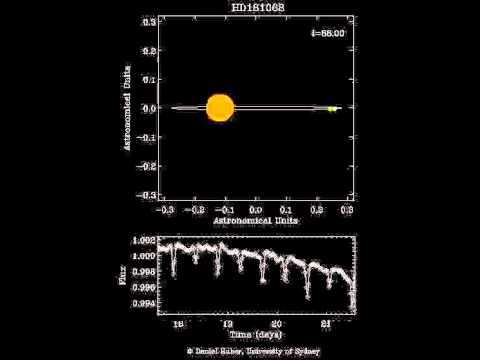

In [3]:
macho_video()

The following figure presents example light-curves of each class in the MACHO survey. The x-axis is the modified Julian Date (MJD), and the y-axis is the MACHO B-magnitude.

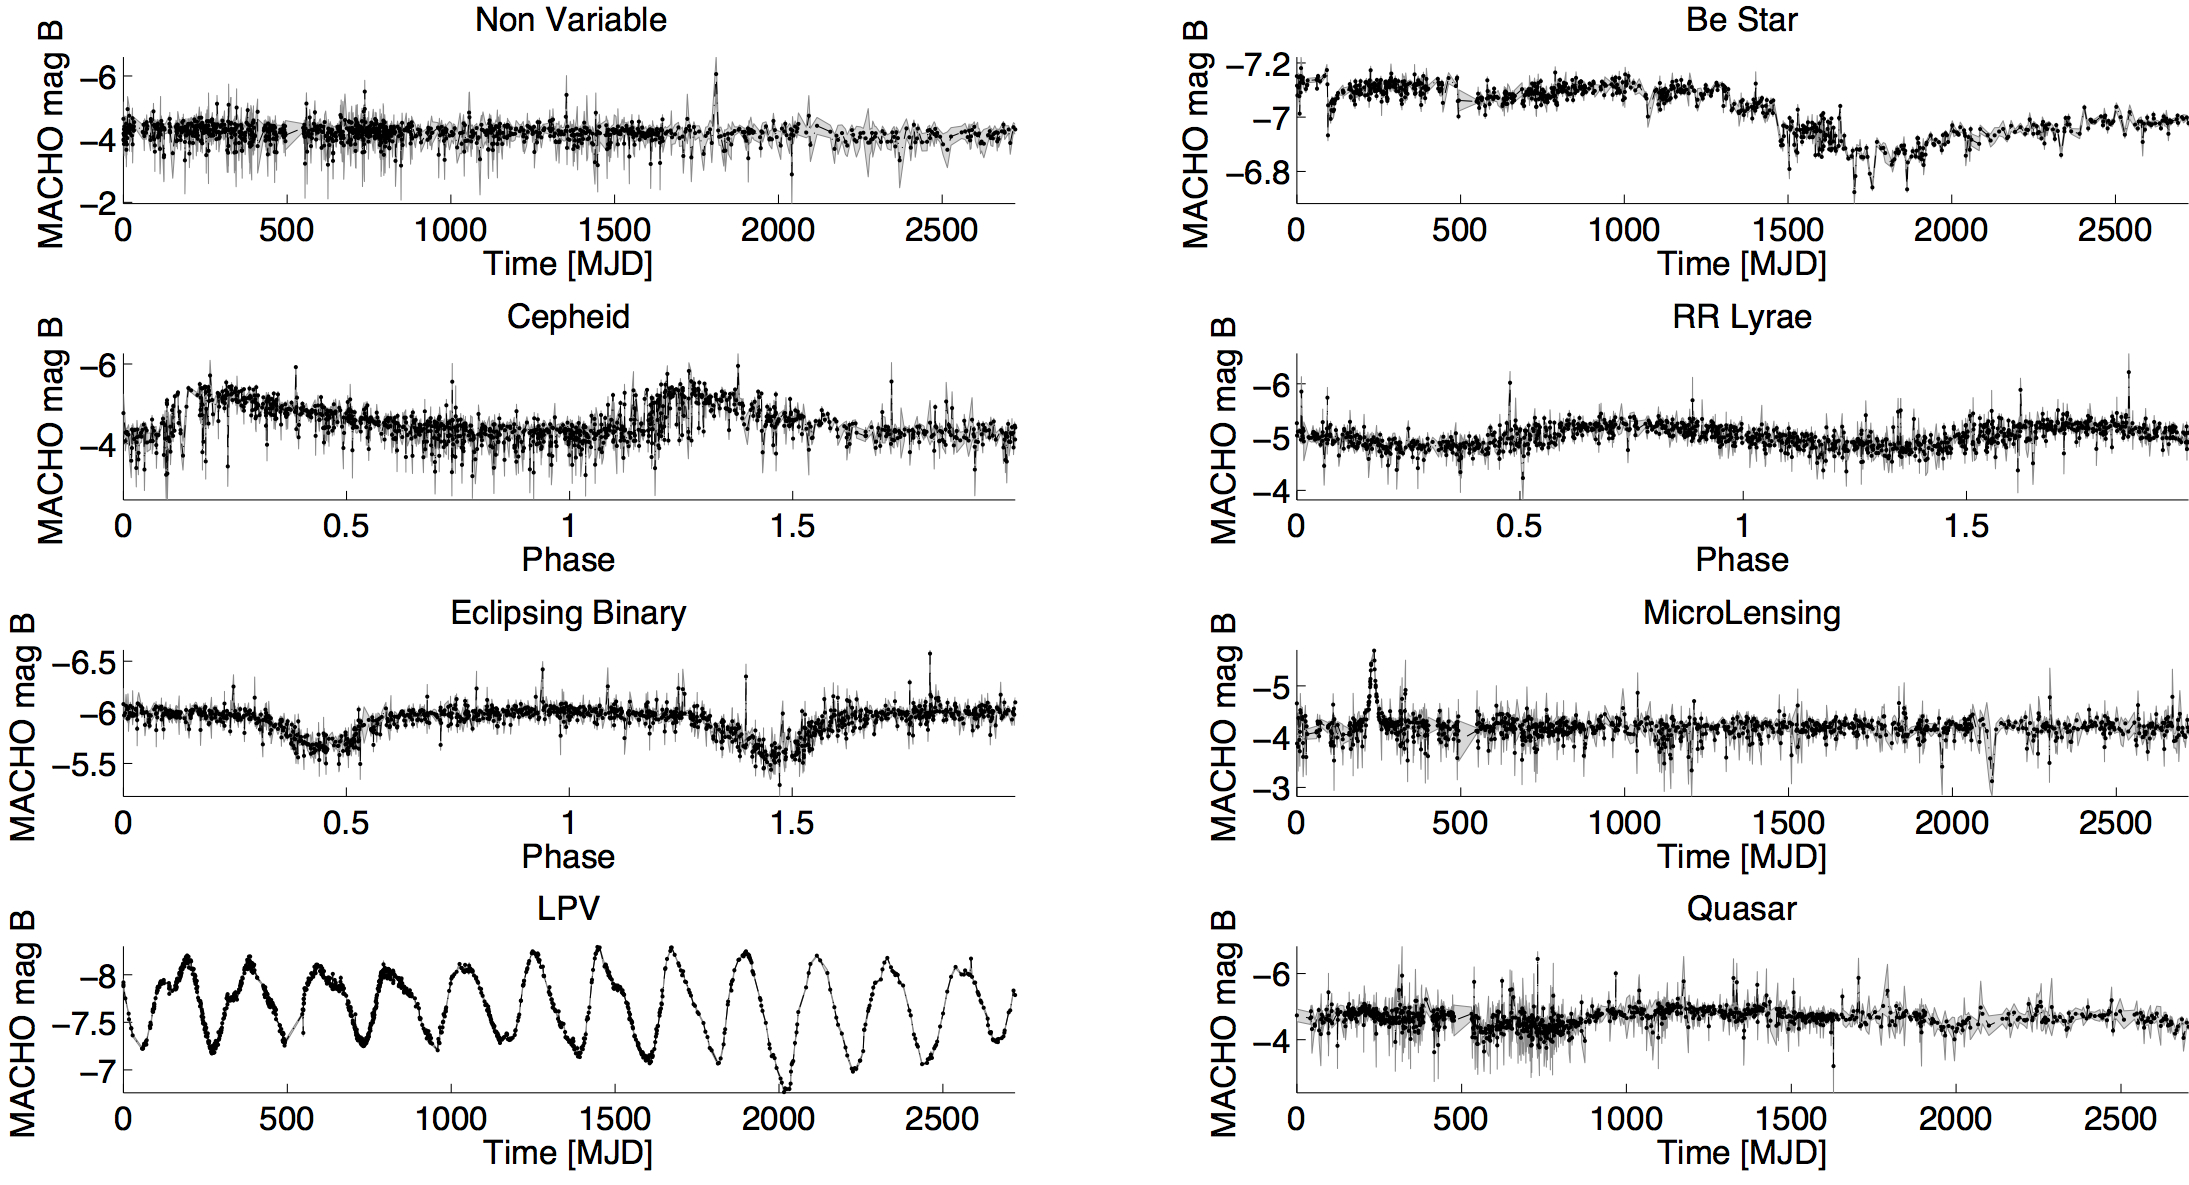

In [4]:
macho_example11()

## Library structure

The library is coded in python and can be downloaded from the Github repository https://github.com/carpyncho/feets. New features may be added by issuing pull requests via the Github version control system. For a quick guide on how to use github visit https://guides.github.com/activities/hello-world/.

It is also possible to obtain the library by downloading the python package from https://pypi.python.org/pypi/feets or by directly installing it from the terminal as follows:

```bash

$ pip install feets
```

The library receives as input the time series data and returns as output an array with the calculated features. 
Depending on the available input the user can calculate different features. For example, if the user has only the vectors magnitude and time, just the features that need this data will be able to be computed.

In order to calculate all the possible features the following vectors (also termed as raw data) are needed per light curve:

- time
- magnitude
- error
- magnitude2
- time2
- error2

where 2 refers to a different observation band. It is worth pointing out that the magnitude vector is the only input strictly required by the library given that it is necessary for the calculation of all the features. The remaining vectors are optional since they are needed just by some features. In other words, if the user does not have this additional data or he is analyzing time series other than light curves, it is still possible to calculate some of the features. More details are presented in the next section.

This is an example of how the input could look like if you have only magnitude and time as input vectors:

In [5]:
lc_example = np.array([time_ex, magnitude_ex])
lc_example

array([[ 0.        ,  1.        ,  2.        ,  3.        ,  4.        ,
         5.        ,  6.        ,  7.        ,  8.        ,  9.        ,
        10.        , 11.        , 12.        , 13.        , 14.        ,
        15.        , 16.        , 17.        , 18.        , 19.        ,
        20.        , 21.        , 22.        , 23.        , 24.        ,
        25.        , 26.        , 27.        , 28.        , 29.        ],
       [ 0.20970975,  0.80204085,  0.28820015,  0.37039011,  0.48115464,
         0.86820313,  0.48979622,  0.22301646,  0.4935109 ,  0.79350497,
         0.97494152,  0.81064321,  0.32671638,  0.20660825,  0.37420108,
         0.72971381,  0.15585522,  0.72447252,  0.34039641,  0.71799426,
         0.81918733,  0.94291775,  0.6184779 ,  0.2298462 ,  0.41711845,
         0.36057235,  0.23657102,  0.41109734,  0.72880648,  0.9590252 ]])

When observed in different bands, light curves of a same object are not always monitored for the same time length and at the same precise times. For some features, it is important to align the light curves and to only consider the simultaneous measurements from both bands. The aligned vectors refer to the arrays obtained by synchronizing the raw data.

Thus, the actual input needed by the library is an array containing the following vectors and in the following order:

-  time
-  magnitude
-  error
-  magnitude2
-  aligned_time
-  aligned_magnitude
-  aligned_magnitude2
-  aligned_error
-  aligned_error2

The library structure is divided into two main parts. 

1. **feets.FeatureSpace**: is a wrapper class that allows the user to select the features to be calculated based 
   on the available time series vectors or to specify a list of features. 
2. **feets.extractors**: A package containing the actual code for calculating the features, and multiple tools to 
   create your own extractor. Each feature has its own extractor class and every extractor can create at leat one 
   feature.
   
The following code is an example of a class in extractors package that calculates the slope of a linear fit to the light-curve:

```python

import feets
from scipy import stats

class LinearTrend(feets.Extractor):  # must inherit from Extractor

    data = ['magnitude', 'time']  # Which data is needed 
                                  # to calculate this feature
    
    features = ["LinearTrend"] # The names of the expected 
                               # feature
    
    # This method receives the data specified in the 
    # previous line with the same name 
    def fit(self, magnitude, time):
        regression_slope = stats.linregress(time, magnitude)[0]
        
        # The return value must be a dict with the same values 
        # defined in  features
        return {"LinearTrend": regression_slope}  
                                                           

```

If the user wants to use their features after the declaration of the extractor they must register the class with the `register` function. For example:

```python
feets.register_extractor(LinearTrend)
```

### Reading example light curve

Feets comes with a [MACHO](http://wwwmacho.anu.edu.au/) Example light-curve,with all the 9 parameters needed to calculate all the posible features.

In [6]:
from feets.datasets import macho

lc = macho.load_MACHO_example()
print("ID:", print(lc.id))
print("Bands:", lc.bands)

lc_1.3444.614
ID: None
Bands: ('R', 'B')


It is sometimes helpful to visualize the data before processing it. For a representation of the light curve, we can plot it as follows:

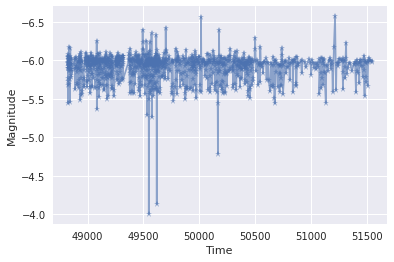

In [7]:
p = plt.plot(lc.data.B.time, lc.data.B.magnitude, '*-', alpha = 0.6)
plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.gca().invert_yaxis()

#### Preproccess

Besides opening the file, the data we noww need to:

- **Remove noise**: points within 5 standard deviations from the mean are considered as noise and thus are eliminated.
- **Align**: it synchronizes the light-curves in the two different bands and returns `aligned_time`, `aligned_magnitude`, `aligned_magnitude2`, `aligned_error` and `aligned_error2`.

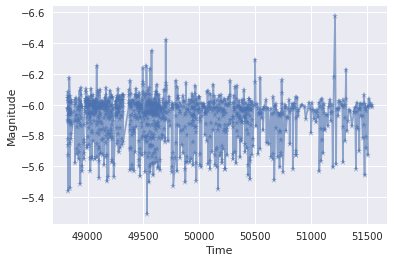

In [8]:
import feets.preprocess

# removing noise of the data
time, mag, error = feets.preprocess.remove_noise(**lc.data.B)
time2, mag2, error2 = feets.preprocess.remove_noise(**lc.data.R)

# We synchronize the data
atime, amag, amag2, aerror, aerror2 = feets.preprocess.align(
    time, time2, mag, mag2, error, error2)

lc = [time, mag, error, 
      mag2, atime, amag, amag2, 
      aerror, aerror2]

plt.plot(lc[0], lc[1], '*-', alpha = 0.6)
plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.gca().invert_yaxis()

### Choosing the features

The library allows the user to either choose the specific features of interest to be calculated or to calculate them all simultaneously. Nevertheless, as already mentioned, the features are divided depending on the input data needed for their computation (magnitude, time, error, second data, etc.). If unspecified, this will be used as an automatic selection parameter. For example, if the user wants to calculate all the available features but only has the vectors magnitude and time, only the features that need magnitude and/or time as an input will be computed.

<div class="alert alert-info admonition note">
**Note:** some features depend on other features or must be computed together. For instance, `Period_fit` returns the false alarm probability of the estimated period. It is necessary then to calculate also the period `PeriodLS`.
</div>

The list of all the possible features with their corresponding input data, additional parameters and literature source is presented in the following table:

In [9]:
features_table()

KeyError: 'Freq2_harmonics_rel_phase_0'

The possible ways of how an user can choose the features from the library to be calculated are presented next.

#### List of features as an input:

The user can specify a list of features as input by specifying the features as a list for the parameter `only`. In the following example, we aim to calculate the standard deviation and Stetson L of the data:

In [11]:
fs = feets.FeatureSpace(only=['Std','StetsonL'])
features, values = fs.extract(*lc).as_arrays()
as_table(features, values)

Std,0.14157317495929828
StetsonL,0.5823703637198997


You can provide the same parameters one by one or by keyword intead of use the unpacking `*lc` way. So the following examples will work:

```python
lc(time, mag, error,
   mag2, atime, amag, amag2, 
   aerror, aerror2)
```

or 

```python
lc(time=time, magnitude=mag, error=error,
   magnitude2=mag2, aligned_time=atime, 
   aligned_magnitude=amag, aligned_magnitude2=amag2, 
   aligned_error=aerror, aligned_error2=aerror2)
```

#### Available data as an input:

In case the user does not have all the input vectors mentioned above, it is necessary to specify the available data by specifying the list of vectors using the parameter `data`. In the example below, we calculate all the features that can be computed with the magnitude and time as an input.

In [12]:
fs = feets.FeatureSpace(data=['magnitude','time'])
features, values = fs.extract(*lc).as_arrays()
as_table(features, values)

Amplitude,0.26500000000000057
AndersonDarling,1.0
Autocor_length,1.0
Con,0.0
DMDT_0_0,0.0
DMDT_0_1,0.0
DMDT_0_2,0.0
DMDT_0_3,0.0
DMDT_0_4,0.0
DMDT_0_5,0.0
DMDT_0_6,0.0


#### List of features and available data as an input.

It is also possible to provide the available time series input vectors and calculate all possible features from a feature list using this data:

In [13]:
fs = feets.FeatureSpace(
    only=['Mean','Beyond1Std','CAR_sigma','Color','SlottedA_length'], 
    data=['magnitude', 'error']) 
features, values = fs.extract(*lc).as_arrays()
as_table(features, values)

Beyond1Std,0.22278056951423786
Mean,-5.917989112227805


#### Excluding list as an input

The user can also create a list of features to be excluded from the calculation. To do so, the list of features to be excluded can be passed as a list via the parameter `exclude`. For example:

In [14]:
fs = feets.FeatureSpace(
    only=['Mean','Beyond1Std','CAR_sigma','Color','SlottedA_length'], 
    data=['magnitude', 'error'],
    exclude=["Beyond1Std"]) 
features, values = fs.extract(*lc).as_arrays()
as_table(features, values)

Mean,-5.917989112227805


#### All the features

To calculate all the existing features in the library, the user only need to instantiate the feature space without parameters

In [15]:
fs = feets.FeatureSpace() 
features, values = fs.extract(*lc).as_arrays()
as_table(features, values)

Amplitude,0.26500000000000057
AndersonDarling,1.0
Autocor_length,1.0
Beyond1Std,0.22278056951423786
CAR_mean,-9.230698873903961
CAR_sigma,-0.2192804929884251
CAR_tau,0.6411203737734862
Color,-0.33325502453332145
Con,0.0
DMDT_0_0,0.0
DMDT_0_1,0.0


<h3 class="text-info">Required data</h3>

The `FeatureSpace` object auto generates the set of required data (stored in `FeatureSpace.required_data_`) based on the `data`, `only` and `exclude` params. If you not provide the required data when you excecute the `extract()` method, an exception is raised. For example

In [16]:
fs = feets.FeatureSpace(only=["PeriodLS"])
fs.required_data_

frozenset({'magnitude', 'time'})

In [17]:
%%expect_exception feets.DataRequiredError

fs.extract(time=time)

---------------------------------------------------------------------------
DataRequiredError                         Traceback (most recent call last)
<ipython-input-17-b1d41c0916d5> in <module>
      1 
----> 2 fs.extract(time=time)

~/proyectos/feets/src/feets/core.py in extract(self, time, magnitude, error, magnitude2, aligned_time, aligned_magnitude, aligned_magnitude2, aligned_error, aligned_error2)
    383             DATA_ALIGNED_MAGNITUDE2: aligned_magnitude2,
    384             DATA_ALIGNED_ERROR: aligned_error,
--> 385             DATA_ALIGNED_ERROR2: aligned_error2})
    386 
    387         features, extractors = {}, {}

~/proyectos/feets/src/feets/core.py in preprocess_timeserie(self, d)
    343         for k, v in d.items():
    344             if k in self._required_data and v is None:
--> 345                 raise DataRequiredError(k)
    346             array_data[k] = v if v is None else np.asarray(v)
    347         return array_data

DataRequiredError: magnitude


#### Features Calculation Precedence

As showed the parameters `data`, `only` and `exclude` can be combinded and the selected features will be calculated in three steps:

1. The `FeatureSpace` select all the features available for the available `data`, otherwise all the features are selected.
2. If the `only` parameter is not `None` then the selected features from the step 1 are filtered only if they exist in the `only` list.
3. If `exclude` is not `None`, then removes the features selected by the step 1 and 2 that are also in `exlude`

### Library output

When calculating the features of a light-curve, the output are two different array.

1. The first one are the names of the calculated features, where thr $i_{nth}$ element represent the
name of the $i_{nth}$ feature.
2. The second array are the values of the features in the same order that the names.

So for example if we want to print the name and the value of the 3rd feature:

In [20]:
fs = feets.FeatureSpace() 
rs = fs.extract(*lc)
features, values = rs.as_arrays()
print(features[2], "=", values[2])

Autocor_length = 1.0


Inother hand this format can be easily converted into a dictionary with the next code:

In [21]:
fdict = rs.as_dict()
fdict

{'Amplitude': 0.26500000000000057,
 'AndersonDarling': 1.0,
 'Autocor_length': 1,
 'Beyond1Std': 0.22278056951423786,
 'CAR_mean': -9.230698873903961,
 'CAR_sigma': -0.2192804929884251,
 'CAR_tau': 0.6411203737734862,
 'Color': -0.33325502453332145,
 'Con': 0.0,
 'DMDT': array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0

## Ploting the example lightcurve in phase

Note: for periodic light-curves we are able to transform the photometric time series into a single light-curve in which each period is mapped onto the same time axis as follows:

$$
t'=\{\frac{t-t_0}{T}\}
$$
 
where  $T$  is the period,  $t_0$  is an arbitrary starting point and the symbol $\{\}$ represents the non-integer part of the fraction. This process produces a folded light-curve on an x-axis of folded time that ranges from 0 to 1. The corresponding folded light-curve of the previous example is shown next:

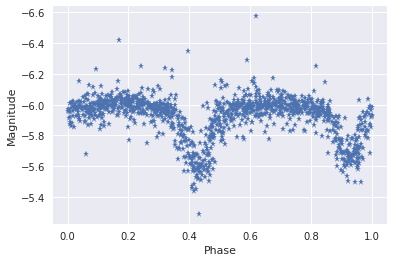

In [22]:
T = 2 * fdict["PeriodLS"]
new_b = np.mod(lc[0], T) / T;
idx = np.argsort(2 * new_b)

plt.plot(new_b, lc[1], '*')
plt.xlabel("Phase")
plt.ylabel("Magnitude")
plt.gca().invert_yaxis()

## The Features

The next section details the features that we have developed in order to
represent light curves. For each feature, we also describe a benchmark test
performed in order to test the feature's correctness.

<div class="alert alert-info admonition note">
Each feature was also tested to ensure invariability to unequal
sampling. Because telescope observations are not always taken at
uniformly spaced intervals, the light curve features should be
invariant to this non-uniformity. These test can be found
[here](https://github.com/carpyncho/feets/blob/master/feets/tests/test_FATS_to_feets.py#L172-L262)
</div>

Let's first assume the existence of some synthetic light-curves in order to
explain each one of the features extractors along the library:

- `lc_normal` : its magnitude follows a Gaussian distribution
- `lc_periodic` : its magnitude has a periodic variability
- `lc_uniform` : its magnitude follows a uniform distribution

In [25]:
features_doc()

TypeError: '<' not supported between instances of 'ExtractorMeta' and 'ExtractorMeta'